# Import and Setup

Adjust cell width to view more content

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

Import general packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import datetime
from matplotlib.patches import Rectangle

Import YLXPS-related packages

In [3]:
import sys 
sys.path.insert(0, '/gpfs/loomis/project/david_moore/aj487/purity_monitor/')
sys.path.insert(0, '/gpfs/loomis/project/david_moore/aj487/purity_monitor/analysis/')
import StandMonitor
import WaveformClass as Wvf
import HelperClasses as HelpC
import RunAnalysis as An
import PlotFunctions as Plt

# Data Read-In

In [4]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

# Analysis

In [5]:
FilePath = '/project/fas/david_moore/zl423/PurityData/20201016/'
Files = sorted(glob.glob(FilePath+'*avg*'))
arg = Namespace(filepath=Files, dirpath=None, txt=False, show=True)
for ii,File in enumerate(Files): 
    print(ii, File)

0 /project/fas/david_moore/zl423/PurityData/20201016/Vacuum_Au-Thorslabs_1mm_C-200V_A-200V_avg_1.h5
1 /project/fas/david_moore/zl423/PurityData/20201016/Vacuum_Au-Thorslabs_1mm_C-200V_A-200V_avg_3.h5
2 /project/fas/david_moore/zl423/PurityData/20201016/Vacuum_Au-Thorslabs_1mm_C-200V_A-200V_avg_4.h5
3 /project/fas/david_moore/zl423/PurityData/20201016/Vacuum_Au-Thorslabs_1mm_C-200V_A-200V_avg_5.h5
4 /project/fas/david_moore/zl423/PurityData/20201016/Vacuum_Au-Thorslabs_1mm_C-200V_A-200V_avg_6.h5


## Argon Measurement
Argon was left in the chamber since September 10. See Jupyter notebook from 20200910 for comparison. 

In [6]:
ch1 = Wvf.WFM(ID=1, Pol=1)
ch2 = Wvf.WFM(ID=2, Pol=-1)
channels = [ch1, ch2]

FileNames, Method = An.ChooseFilesToAnalyze(arg)
for File in FileNames: 
    An.ImportDataFromHDF5(File, channels)

An.DoAnalysis(channels)

ChargeCollection = ch1.Max / ch2.Max
DiffMinute = int((np.max(ch1.TimeStamp) - np.min(ch1.TimeStamp)).seconds/60.0 + 0.5)
XTicks = int((DiffMinute/12.0 + 0.5))+1
print(np.mean(ChargeCollection))
print(np.std(ChargeCollection)/np.sqrt(len(ChargeCollection)))

 | Filename... /project/fas/david_moore/zl423/PurityData/20201016/Vacuum_Au-Thorslabs_1mm_C-200V_A-200V_avg_1.h5
 | Number of files in ch1...	 10/10
 | Number of files in ch2...	 10/10
 | Filename... /project/fas/david_moore/zl423/PurityData/20201016/Vacuum_Au-Thorslabs_1mm_C-200V_A-200V_avg_3.h5
 | Number of files in ch1...	 12/22
 | Number of files in ch2...	 12/22
 | Filename... /project/fas/david_moore/zl423/PurityData/20201016/Vacuum_Au-Thorslabs_1mm_C-200V_A-200V_avg_4.h5
 | Number of files in ch1...	 14/36
 | Number of files in ch2...	 14/36
 | Filename... /project/fas/david_moore/zl423/PurityData/20201016/Vacuum_Au-Thorslabs_1mm_C-200V_A-200V_avg_5.h5
 | Number of files in ch1...	 20/56
 | Number of files in ch2...	 20/56
 | Filename... /project/fas/david_moore/zl423/PurityData/20201016/Vacuum_Au-Thorslabs_1mm_C-200V_A-200V_avg_6.h5
 | Number of files in ch1...	 533/589
 | Number of files in ch2...	 533/589
 | Processing data in channel 1...
 | Processing data in channel 2...
 

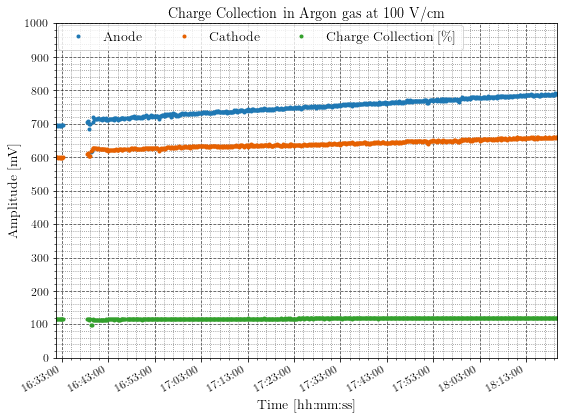

In [7]:
Plt.PltTime(Time=ch1.TimeStamp,
            Data=[ch1.Max,ch2.Max,ChargeCollection*100],
            Legend=['Anode','Cathode','Charge Collection [\%]'],
            Label='Amplitude [mV]',
            XTicks=XTicks,
            YTicks=100,
            YRange=[0,1000],
            SaveName='amp_ratio',
            Title='Charge Collection in Argon gas at 100 V/cm',
            Save=False)
# plt.savefig('amp.pdf', bbox_inches='tight')

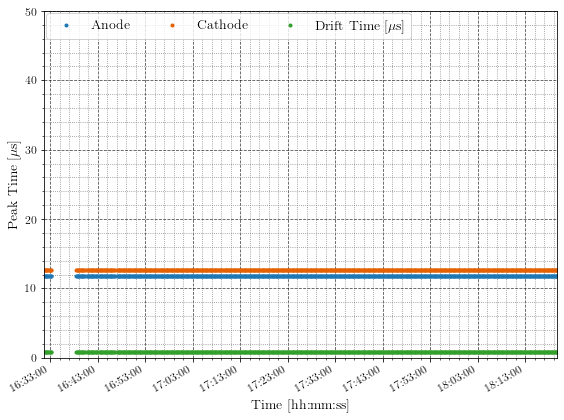

In [8]:
Plt.PltTime(Time=ch1.TimeStamp,
        Data=[ch1.GradTime,ch2.GradTime,ch2.GradTime - ch1.GradTime],
        Legend=['Anode','Cathode','Drift Time [$\mu$s]'],
        Label='Peak Time [$\mu$s]',
        XTicks=XTicks,
        YTicks=10,
        YRange=[0,50],
        SaveName='drift_time',
        Save=False)

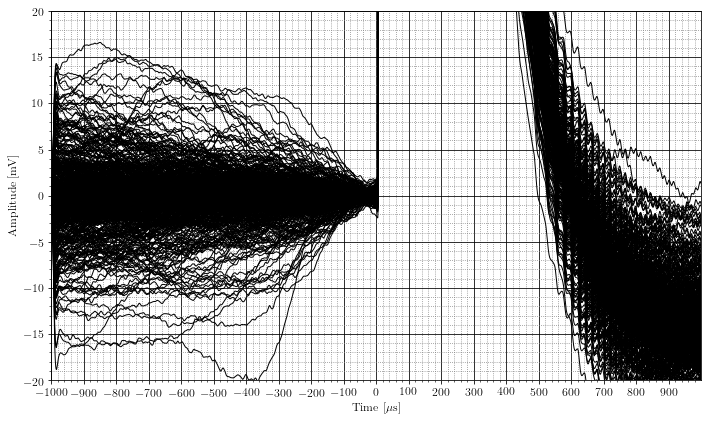

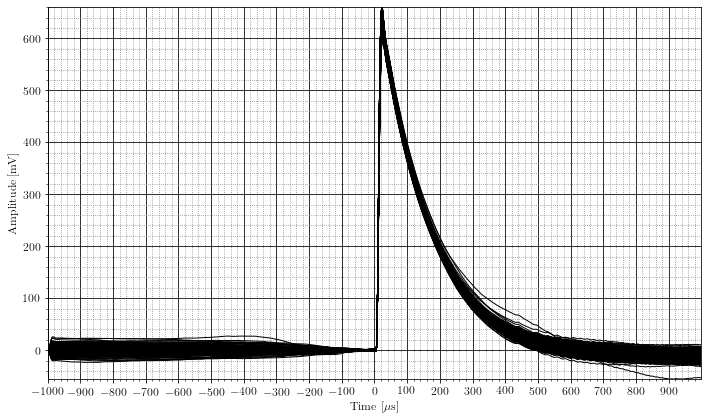

In [9]:
Plt.PltWfm(Time=ch1.Time,
           Data=list(ch1.AmpClean),
           Legend=['Anode'],
           XTicks=100,
           YTicks=5,
           SaveName='avg_waveform',
           Color='k')
plt.ylim(-20,20)

Plt.PltWfm(Time=ch2.Time,
           Data=list(ch2.AmpClean),
           Legend=['Cathode'],
           XTicks=100,
           YTicks=100,
           SaveName='avg_waveform',
           Color='k')

2.2913899888354092


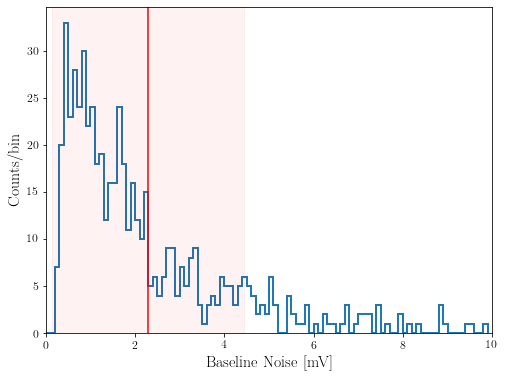

In [10]:
endbin = ch1.FindTimeBin(-100)

noise = []
for x in ch1.AmpClean: 
    nn = np.std(x[:endbin])
    nn = np.sqrt(np.mean(x[:endbin]**2))
    noise.append(nn)
    
    
noise_avg = np.mean(noise)
noise_err = np.std(noise)
    
print(np.mean(noise))
fig = plt.figure(figsize=(8,6))
plt.xlim(0,10)
plt.hist(noise, bins=np.arange(0.0,10.0,0.1), histtype='step', align='mid', lw=2)
plt.xlabel('Baseline Noise [mV]', fontsize=16)
plt.ylabel('Counts/bin', fontsize=16)
plt.axvline(noise_avg, color='red')
# plt.title('Charge Collection = %.4f ± %.4f' % (avg,err))
rectangle = plt.Rectangle((noise_avg-noise_err,0), 2*noise_err, 100, fc='red',ec="red", alpha=0.05, fill=True)
plt.gca().add_patch(rectangle)
# plt.savefig('chargecollection_hist.pdf',bbox_inches='tight')
    

In [11]:
avg = np.mean(ChargeCollection)
err = np.std(ChargeCollection)/np.sqrt(len(ChargeCollection))

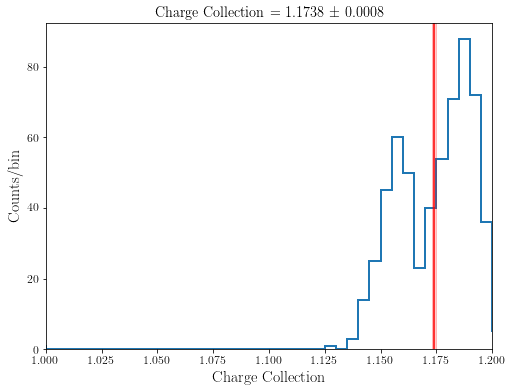

In [12]:
fig = plt.figure(figsize=(8,6))
plt.xlim(1.0,1.2)
plt.hist(ChargeCollection, bins=np.arange(0.0,2.0,0.005), histtype='step', align='mid', lw=2)
plt.xlabel('Charge Collection', fontsize=16)
plt.ylabel('Counts/bin', fontsize=16)
plt.axvline(avg, color='red')
plt.title('Charge Collection = %.4f ± %.4f' % (avg,err))
rectangle = plt.Rectangle((avg-err,0), 2*err, 100, fc='red',ec="red", alpha=0.2, fill=True)
plt.gca().add_patch(rectangle)
plt.savefig('chargecollection_hist.pdf',bbox_inches='tight')